In [1]:
import numpy as np
import struct
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from copy import deepcopy
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
from scipy import spatial
from util.util import mnist_noise, correct_prob
from util.util import ImbalancedDatasetSampler

from trajectoryReweight.model import WeightedCrossEntropyLoss, TrajectoryReweightNN
from trajectoryReweight.baseline import StandardTrainingNN
from trajectoryReweight.gmm import GaussianMixture

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

cuda:0


In [2]:
"""
CNN & LeNet
"""
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def name(self):
        return "LeNet"

def accuracy(predict_y, test_y):
    score = 0
    for pred, acc in zip(predict_y, test_y):
        if pred == acc:
            score +=1
    return score / test_y.shape[0]

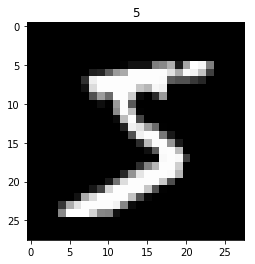

In [3]:
"""
MNIST DATA
"""
x_train = read_idx('data/train-images.idx3-ubyte')
y_train = read_idx('data/train-labels.idx1-ubyte')
x_test = read_idx('data/t10k-images.idx3-ubyte')
y_test = read_idx('data/t10k-labels.idx1-ubyte')
valid_idx = np.random.choice(range(60000), size=1000, replace=False)
x_valid = x_train[valid_idx]
y_valid = y_train[valid_idx]
x_train = np.delete(x_train, valid_idx, axis=0)
y_train = np.delete(y_train, valid_idx)

"""
shrink dataset to make noisy significant
"""
# x_train = x_train[:10000]
# y_train = y_train[:10000]

"""
Add Noise to training data
"""
y_train_noisy = mnist_noise(y_train,0.8)

"""
Plot an example
""" 
plt.imshow(x_train[0], cmap='gray')
plt.title('%i' % y_train[0])
plt.show()

In [4]:
"""
Initializaion
"""
train_idx = np.arange(len(x_train))
x_train = np.transpose(x_train,(2,1,0))
x_valid = np.transpose(x_valid,(2,1,0))
x_test = np.transpose(x_test,(2,1,0))
x_train_tensor = torchvision.transforms.ToTensor()(x_train).unsqueeze(1)
x_valid_tensor = torchvision.transforms.ToTensor()(x_valid).unsqueeze(1)
x_test_tensor = torchvision.transforms.ToTensor()(x_test).unsqueeze(1)
y_train_tensor = torch.from_numpy(y_train.astype(np.long))
y_train_noisy_tensor = torch.from_numpy(y_train_noisy.astype(np.long))
y_valid_tensor = torch.from_numpy(y_valid.astype(np.long))
y_test_tensor = torch.from_numpy(y_test.astype(np.long))

In [ ]:
"""
CNN without reweight
"""
cnn = CNN()
cnn.to(device)

stand_trainNN = StandardTrainingNN(cnn,
                                   batch_size=64,
                                   num_iter=80,
                                   learning_rate=1e-3,
                                   early_stopping=5,
                                   iprint=1)
stand_trainNN.fit(x_train_tensor, y_train_noisy_tensor, x_valid_tensor, y_valid_tensor, x_test_tensor, y_test_tensor, device)

test_output_y = stand_trainNN.predict(x_test_tensor,device)
test_accuracy = accuracy(test_output_y, y_test_tensor.data.numpy())

print('test accuracy is {}%'.format(100 * test_accuracy))

In [5]:
"""
CNN with reweight
"""
cnn = CNN()
cnn.to(device)

tra_weightNN = TrajectoryReweightNN(cnn,
                                    burnin=5,
                                    num_cluster=10,
                                    batch_size=64,
                                    num_iter=75,
                                    learning_rate=1e-3,
                                    early_stopping=5,
                                    device=device,
                                    iprint=1)
tra_weightNN.fit(x_train_tensor, y_train_noisy_tensor, x_valid_tensor, y_valid_tensor,x_test_tensor, y_test_tensor)

test_output_y = tra_weightNN.predict(x_test_tensor)
test_accuracy = accuracy(test_output_y, y_test_tensor.data.numpy())

print('test accuracy is {}%'.format(100 * test_accuracy))

Train 5 burn-in epoch...
Train 5 burn-in epoch complete.
------------------------------------------------------------
Trajectory clustering for burn-in epoch...
Trajectory clustering for burn-in epoch complete.
------------------------------------------------------------
Trajectory based training start ...

epoch = 6 | training loss = 2.1518 | valid loss = 1.9676 | early stopping = 0/5 | test loss = 0.0308 | test accuarcy = 83.06% [8306/10000]
epoch = 7 | training loss = 2.1494 | valid loss = 1.9927 | early stopping = 1/5 | test loss = 0.0312 | test accuarcy = 87.63% [8763/10000]
epoch = 8 | training loss = 2.2574 | valid loss = 1.9487 | early stopping = 0/5 | test loss = 0.0306 | test accuarcy = 90.67% [9067/10000]
epoch = 9 | training loss = 2.2550 | valid loss = 1.8971 | early stopping = 0/5 | test loss = 0.0298 | test accuarcy = 92.75% [9275/10000]
epoch = 10 | training loss = 2.2539 | valid loss = 1.8919 | early stopping = 0/5 | test loss = 0.0297 | test accuarcy = 90.88% [9088/10

In [ ]:
"""
Repeat 10 times
"""

std_test = []
rewgt_test = []

for rep in range(10):
    """
    prepare data
    """
    x_train = read_idx('data/train-images.idx3-ubyte')
    y_train = read_idx('data/train-labels.idx1-ubyte')
    x_test = read_idx('data/t10k-images.idx3-ubyte')
    y_test = read_idx('data/t10k-labels.idx1-ubyte')
    valid_idx = np.random.choice(range(60000), size=1000, replace=False)
    x_valid = x_train[valid_idx]
    y_valid = y_train[valid_idx]
    x_train = np.delete(x_train, valid_idx, axis=0)
    y_train = np.delete(y_train, valid_idx)

    """
    shrink dataset to make noisy significant
    """
#     x_train = x_train[:10000]
#     y_train = y_train[:10000]

    """
    Add Noise to training data
    """
    y_train_noisy = mnist_noise(y_train,0.1)
    
    """
    to tensor
    """
    train_idx = np.arange(len(x_train))
    x_train = np.transpose(x_train,(2,1,0))
    x_valid = np.transpose(x_valid,(2,1,0))
    x_test = np.transpose(x_test,(2,1,0))
    x_train_tensor = torchvision.transforms.ToTensor()(x_train).unsqueeze(1)
    x_valid_tensor = torchvision.transforms.ToTensor()(x_valid).unsqueeze(1)
    x_test_tensor = torchvision.transforms.ToTensor()(x_test).unsqueeze(1)
    y_train_tensor = torch.from_numpy(y_train.astype(np.long))
    y_train_noisy_tensor = torch.from_numpy(y_train_noisy.astype(np.long))
    y_valid_tensor = torch.from_numpy(y_valid.astype(np.long))
    y_test_tensor = torch.from_numpy(y_test.astype(np.long))
    
    """
    comparing
    """
    cnn = CNN()
    cnn.to(device)

    stand_trainNN = StandardTrainingNN(cnn,
                                       batch_size=64, 
                                       num_iter=80,
                                       learning_rate=0.001,
                                       early_stopping=5,
                                       iprint=0)
    stand_trainNN.fit(x_train_tensor, y_train_noisy_tensor, x_valid_tensor, y_valid_tensor,device)
    test_output_y = stand_trainNN.predict(x_test_tensor,device)
    test_accuracy = accuracy(test_output_y, y_test_tensor.data.numpy())
    std_test.append(test_accuracy)
    
    time.sleep(10)
    
    cnn = CNN()
    cnn.to(device)

    tra_weightNN = TrajectoryReweightNN(cnn,
                                        burnin=5, 
                                        num_cluster=10,
                                        batch_size=64, 
                                        num_iter=75,
                                        learning_rate=0.001,
                                        early_stopping=5,
                                        iprint=0)
    tra_weightNN.fit(x_train_tensor, y_train_noisy_tensor, x_valid_tensor, y_valid_tensor,device)
    test_output_y = tra_weightNN.predict(x_test_tensor,device)
    test_accuracy = accuracy(test_output_y, y_test_tensor.data.numpy())
    rewgt_test.append(test_accuracy)
    
    time.sleep(10)
    
    print('running {}/10'.format(rep+1))

In [ ]:
print(std_test)
print(rewgt_test)
print(np.mean(std_test),np.mean(rewgt_test))

In [ ]:
"""
Imbalanced MNIST DATA
"""
x_train = read_idx('data/train-images.idx3-ubyte')
y_train = read_idx('data/train-labels.idx1-ubyte')
x_test = read_idx('data/t10k-images.idx3-ubyte')
y_test = read_idx('data/t10k-labels.idx1-ubyte')

four_index = y_train == 4
nine_index = y_train == 9

y_fours = y_train[four_index]-4
y_nines = y_train[nine_index]-8
x_fours = x_train[four_index]
x_nines = x_train[nine_index]

valid_four_index = np.random.choice(range(len(y_fours)), size=250, replace=False)
valid_nine_index = np.random.choice(range(len(y_nines)), size=250, replace=False)

x_valid_four =  x_fours[valid_four_index]
x_valid_nine =  x_nines[valid_nine_index]
y_valid_four =  y_fours[valid_four_index]
y_valid_nine =  y_nines[valid_nine_index]

x_valid = np.append(x_valid_four,x_valid_nine,0)
y_valid = np.append(y_valid_four,y_valid_nine)
indices = np.arange(x_valid.shape[0])
np.random.shuffle(indices)
x_valid = x_valid[indices]
y_valid = y_valid[indices]

x_train_four = np.delete(x_fours, valid_four_index, axis=0)
y_train_four = np.delete(y_fours, valid_four_index)
x_train_nine = np.delete(x_nines, valid_four_index, axis=0)
y_train_nine = np.delete(y_nines, valid_four_index)

four_index = dataset['y_test'] == 4
nine_index = dataset['y_test'] == 9

y_fours = dataset['y_test'][four_index]-4
y_nines = dataset['y_test'][nine_index]-8
x_fours = dataset['x_test'][four_index]
x_nines = dataset['x_test'][nine_index]
x_test = np.append(x_fours,x_nines,0)
y_test = np.append(y_fours,y_nines)
indices = np.arange(x_test.shape[0])
np.random.shuffle(indices)
x_test = x_test[indices]
y_test = y_test[indices]

In [ ]:
"""
Imbalanced MNIST Study
""" 
a = [500,250,150,50,25]

ratio = 500
print('ratio: 4:9 = {}:{}'.format(ratio, 5000-ratio))
four_part = np.random.choice(range(len(x_train_four)), size=ratio, replace=False)
nine_part = np.random.choice(range(len(x_train_nine)), size=5000-ratio, replace=False)
x_train = np.append(x_train_four[four_part],x_train_nine[nine_part],0)
y_train = np.append(y_train_four[four_part],y_train_nine[nine_part])
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]


x_train = np.transpose(x_train,(2,1,0))
x_valid = np.transpose(x_valid,(2,1,0))
x_test = np.transpose(x_test,(2,1,0))
x_train_tensor = torchvision.transforms.ToTensor()(x_train).unsqueeze(1)
x_valid_tensor = torchvision.transforms.ToTensor()(x_valid).unsqueeze(1)
x_test_tensor = torchvision.transforms.ToTensor()(x_test).unsqueeze(1)
y_train_tensor = torch.from_numpy(y_train.astype(np.long))
y_valid_tensor = torch.from_numpy(y_valid.astype(np.long))
y_test_tensor = torch.from_numpy(y_test.astype(np.long))

In [ ]:
"""
Imbalanced MNIST without reweight
"""
lenet = LeNet()
lenet.to(device)

stand_trainNN = StandardTrainingNN(lenet,
                                   batch_size=100, 
                                   num_iter=80,
                                   learning_rate=1e-3,
                                   early_stopping=10,
                                   iprint=1)
stand_trainNN.fit(x_train_tensor, y_train_tensor, x_valid_tensor, y_valid_tensor,device)

test_output_y = stand_trainNN.predict(x_test_tensor,device)
test_accuracy = accuracy(test_output_y, y_test_tensor.data.numpy())

print('test accuracy is {}'.format(test_accuracy))

In [ ]:
"""
Imbalanced MNIST with reweight
"""
lenet = LeNet()
lenet.to(device)

tra_weightNN = TrajectoryReweightNN(lenet,
                                    burnin=10, 
                                    num_cluster=5,
                                    batch_size=50, 
                                    num_iter=70, 
                                    learning_rate=1e-3,
                                    early_stopping=10,
                                    iprint=1)
tra_weightNN.fit(x_train_tensor, y_train_tensor, x_valid_tensor, y_valid_tensor,device)

test_output_y = tra_weightNN.predict(x_test_tensor,device)
test_accuracy = accuracy(test_output_y, y_test_tensor.data.numpy())

print('test accuracy is {}'.format(test_accuracy))

In [ ]:
std_test = []
rewgt_test = []
for rep in range(10):
    lenet = LeNet()
    lenet.to(device)

    stand_trainNN = StandardTrainingNN(lenet,
                                       batch_size=50, 
                                       num_iter=80,
                                       learning_rate=1e-3,
                                       early_stopping=10,
                                       iprint=0)
    stand_trainNN.fit(x_train_tensor, y_train_tensor, x_valid_tensor, y_valid_tensor,device)

    test_output_y = stand_trainNN.predict(x_test_tensor,device)
    test_accuracy = accuracy(test_output_y, y_test_tensor.data.numpy())
    std_test.append(test_accuracy)
    
    time.sleep(10)
    
    lenet = LeNet()
    lenet.to(device)

    tra_weightNN = TrajectoryReweightNN(lenet,
                                        burnin=10, 
                                        num_cluster=5,
                                        batch_size=50, 
                                        num_iter=70, 
                                        learning_rate=1e-3,
                                        early_stopping=10,
                                        iprint=0)
    tra_weightNN.fit(x_train_tensor, y_train_tensor, x_valid_tensor, y_valid_tensor,device)

    test_output_y = tra_weightNN.predict(x_test_tensor,device)
    test_accuracy = accuracy(test_output_y, y_test_tensor.data.numpy())
    rewgt_test.append(test_accuracy)
    
    time.sleep(10)
    
    print('running {}/10'.format(rep))

In [ ]:
print(std_test)
print(rewgt_test)
print(np.mean(std_test),np.mean(rewgt_test))